## 3-2. ニューラルネットと誤差関数
ニューラルネットワークを構成する基本要素を説明した後、深層ニューラルネットを導入します。

### 特徴量
入力ベクトル ${\bf x}$ が与えられたときの何らかの変数 $y$ についての条件付き確率 $q_\theta(y|{\bf x})$ を構成するのですが、また具体例を見てみましょう

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def get_2d_simple_data(t, v1=.02, v2=.02):
    return np.random.multivariate_normal([np.cos(t), np.sin(t)], np.diagflat([v1, v2]), 100).astype(np.float32)
    
def two_pairplot(x12):
    df_x1 = pd.DataFrame(x12[0], columns=[r"${\bf x}^1$", r"${\bf x}^2$"]); df_x1["class"] = 'y=A'
    df_x2 = pd.DataFrame(x12[1], columns=[r"${\bf x}^1$", r"${\bf x}^2$"]); df_x2["class"] = 'y=B'
    df = pd.concat([df_x1, df_x2])
    sns.pairplot(df, hue="class");
    plt.show()

例えば2次元データとラベル $\{ ({\bf x}_n, y_n  )\}$ で以下のようなデータがあったとします：

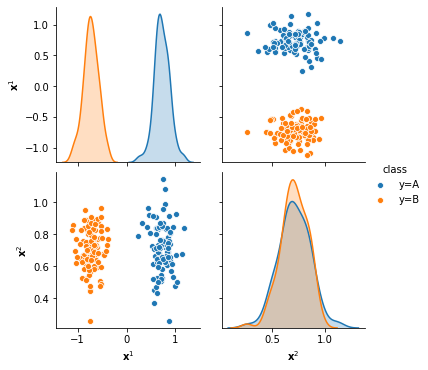

In [20]:
x_A = get_2d_simple_data(t=np.pi/4)
x_B = get_2d_simple_data(t=np.pi/4+np.pi/2)
two_pairplot([x_A, x_B])

この二次元データは ${\bf x}$ の 第一座標 ${\bf x}^1$ でみると、クラスAとクラスBが分かれているけれど、第二座標 ${\bf x}^2$ でデータを見ると、両者の違いが無いように見えます。例えば、このような場合は ${\bf x}$ に適当な線形変換 $l$ をかけた

$$
{\bf z} = l({\bf x}) = W {\bf x} + {\bf b}
$$

を考えると、どちらの座標でも統計量が区別されるのがわかります。線形変換は深層学習ライブラリで簡単に実装できます。

#### 実装その1(Tensorflow)
Tensorflowはバージョン2以後、eager modeと呼ばれる仕様がデフォルトとなり、格段に使いやすくなりました。あんまり難しいことをしない場合、最良だと思います：

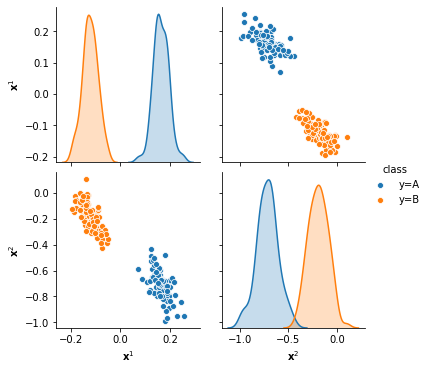

In [21]:
# tensorflowの場合
import tensorflow as tf

l = tf.keras.layers.Dense(2, input_shape=(2,)) # これが線形変換
z_A = l(x_A)
z_B = l(x_B)

two_pairplot([z_A, z_B])

#### 実装その2(PyTorch)
PyTorchは上のtensorflow eager modeの元となった**define-and-run**方式と呼ばれる方式を早くから取り込んだライブラリで、近年では研究者への人気が高まっていけいるようです。
> define-and-run方式を「最初に発明」したのは日本の企業[Preferred Networks](https://preferred.jp/ja/)の、[Chainer](https://chainer.org)という深層学習ライブラリです。

tensorflow eager modeでは忖度してくれていた配列の「型のようなもの」を明示的に指定する必要があります。pytorch(torch)内の関数などを使うときは`np.array`ではなく`torch.tensor`に変換せねばならず、tensorflow eager modeのように楽ちんな書き方は今のところできないようです。

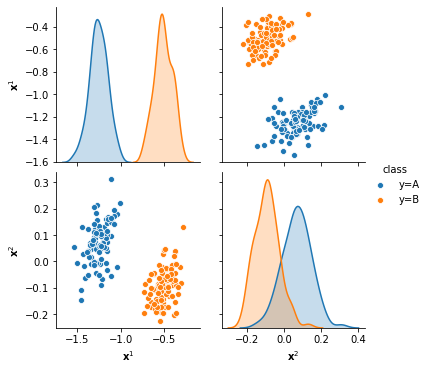

In [23]:
# pytorchの場合
import torch

l = torch.nn.Linear(2,2) # これが線形変換
z_A = l(torch.from_numpy(x_A))
z_B = l(torch.from_numpy(x_B))

two_pairplot([z_A.data.numpy(), z_B.data.numpy()])

#### 一般の特徴量
より一般に、非線形変換 $f$ で

$$
{\bf z} = f({\bf x})
$$

が分類などのタスクをより処理しやすくする、データの背後にある何らかの特徴を抽出した量になっているとき、これを**特徴量(feature)**と言います。以下ではニューラルネットワークにおける特徴量の設計が、何らかの確率モデルについての**期待値**を層状に重ねたものと解釈できることを説明します。

### 2値ユニット
2値分類とは入力$x$を2値のラベルに分類する問題です。ここでは慣習に従い1ビット$\{ 0, 1\}$への分類とします。また、入力は簡単のため1成分の実数としましょう
\begin{align}
y \in \{0, 1\},
\quad
x \in \mathbb{R}
\end{align}
このような状況で条件付き確率$q_\theta(y|x)$を構成するにあたって、統計力学の考えを使いましょう。
統計力学の教えるところによると、
\begin{align}
\text{自由度}: y,
\quad
\text{そのエネルギー}: E(y)
\end{align}
の系が温度$T$の環境下で定常状態に落ち着けば、$y$の実現確率は
\begin{align}
q_E(y)
=
\frac{e^{- \frac{E(y)}{k_B T}}}{Z}
\end{align}
になるのでした。あとはエネルギーを考えれば良さそうです。
まずは外部から力$F(x)$がかかっている状況を考えます。このとき$y$が実数であれば、これを変化分と考えて、仕事は$F(x) y$と考えるのが自然でしょう。いま$y$は2値ですが、スピン変数とみなせば$F$は外部磁場と考えれば同じことです。注がれた仕事がエネルギーになるので
\begin{align}
E(y) = -F(x) y
\end{align}
でしょう。
$x$の依存性がまだないので、$F(x)$として一番単純な
\begin{align}
F(x) = w x + b
\end{align}
を取ることにしてみます。
ここで$w, b$のスケールを適当に合わせれば$k_B T$はこれらの値に吸収できるので
\begin{align}
q_E(y)
=
q_{w, b} (y|x)
=
\frac{e^{(w x + b)y}}{Z}
\end{align}
となります。$Z$は$y=0,1$についての足し算が1になるようにすれば良いので
\begin{align}
Z
=
\sum_{y=0, 1}
e^{(w x + b)y}
=
1 + e^{wx +b}
\end{align}
であることがわかります\footnote{
統計力学で分配関数と呼ばれる量です。
}。
従って
\begin{align}
q_{w, b} (y|x)
=
\frac{e^{(w x + b)y}}{1 + e^{wx +b}}
\end{align}
ということになりました。
これは非常にシンプルな確率モデルです。$y=0,1$である確率はそれぞれ
\begin{align}
&q_{w, b} (y=1|x)
=
\frac{e^{w x + b}}{1 + e^{wx +b}}
=
\frac{1}{e^{-(w x + b)} + 1}
:=
\sigma(wx + b)
\\
&q_{w, b} (y=0|x)
=
1- q_{w, b} (y=1|x)
=
1 - \sigma(wx + b)
\end{align}
と書くことができます。関数$\sigma$には名前がついており、(ロジスティック)シグモイド関数と呼ばれます。
特に$y$の期待値
\begin{align}
\bra y \ket_{q_{w, b}(y|x)}
&=
1 \cdot q_{w, b} (y=1|x) + 0 \cdot q_{w, b} (y=0|x)
\notag \\
&= %%%%
\sigma(wx + b)
\label{211}
\end{align}
がシグモイド関数だけで書けているのが、後々のポイントとなります。
この場合の「{\color{red}汎化誤差}」の近似、「{\color{blue}経験誤差}」${\color{blue}
- \bra \log q_\theta(y|x) \ket_{\hat{p}_N}}$はどうなるか見てみますと、
\begin{align}
- \bra \log q_{w, b}(y|x) \ket_{\hat{p}_N}
&=
- \frac{1}{N} \sum_{n=1}^N \log q_{w, b} (y_n | x_n)
\notag \\
&= %%%%
- \frac{1}{N} \Big(
 \sum_{y_n=1} \log q_{w, b} (y_n=1 | x_n)
 +
  \sum_{y_n=0} \log q_{w, b} (y_n=0 | x_n)
 \Big)
\notag \\
&= %%%%
- \frac{1}{N} \Big(
 \sum_{y_n=1} \log \underbrace{ \sigma (wx_n+b) }_{\bra y \ket_{q_{w, b}(y|x_n)}}
 +
  \sum_{y_n=0} \log \{ 1 - \underbrace{ \sigma (wx_n+b)}_{\bra y \ket_{q_{w, b}(y|x_n)}} \}
 \Big)
\notag \\
&= %%%%
\frac{1}{N} 
\sum_{n=1}^N
\underbrace{
-
\Big(
y_n \log \bra y \ket_{q_{w, b}(y|x_n)}
 +
(1-y_n) \log \{ 1 - \bra y \ket_{q_{w, b}(y|x_n)} \}
 \Big)
 }_{=: l_\text{sig} \Big( \bra y \ket_{q_{w, b}(y|x_n)} ,\ y_n \Big)}
 \notag \\
&= %%%%
\frac{1}{N} 
\sum_{n=1}^N
 l_\text{sig} \Big( \bra y \ket_{q_{w, b}(y|x_n)} ,\ y_n \Big)
\end{align}
と、シグモイドクロスエントロピーと呼ばれる関数
\begin{align}
l_\text{sig} (\bra y \ket, y)
:=
- \Big(y \log \bra y \ket + (1-y) \log (1- \bra y \ket) \Big)
\end{align}
のサンプル平均として書くことができます。
入力の次元が上がって
\begin{align}
\vec{x} = (x^1, x^2, \dots, x^L) \in \mathbb{R}^L
\end{align}
となった場合も、エネルギーを
\begin{align}
E(y)
=
- (\vec{w}^\top \vec{x} +b)y
\end{align}
として同じことが繰り返せるため、
\begin{align}
&q_{\vec{w}, b}(y=1|\vec{x})
=
\sigma (\vec{w}^\top \vec{x} +b)
=
\bra y \ket_{q}
,
\\
&-\bra \log q_{\vec{w}, b}(y|\vec{x}) \ket_{\hat{p}_N}
=
\frac{1}{N} \sum_{n=1}^N
l_\text{sig} \Big(\bra y \ket_{q} , y_n \Big)
\end{align}
がわかります。